# Read dataset

In [8]:
import pandas as pd
import numpy as np
from ml_functions import *

df = pd.read_csv('toy_dataset.csv', index_col=0)

df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

display(df.head())
print(df.shape)

,r1,r3,r2,r4,r5,r6,r7,r8,r9,r10,...,r15,r16,InputA,InputI,OutputX,OutputN,id,growth,status,strain
0,0.0,0.1,-0.1,-0.2,1.2,1.0,1.0,1.0,1.0,-6.938894e-17,...,0.0,1.0,1.0,1.0,3.0,1.0,r1,3.0,infeasible,1
1,1.0,0.0,1.0,2.0,1.0,3.0,3.0,3.0,1.0,0.000000e+00,...,0.0,2.0,1.0,1.0,9.0,1.0,r3,9.0,optimal,1
2,1.0,1.0,0.0,0.0,3.0,3.0,3.0,3.0,1.0,0.000000e+00,...,0.0,2.0,1.0,1.0,9.0,1.0,r2,9.0,optimal,1
3,1.0,1.0,0.0,0.0,3.0,3.0,3.0,3.0,1.0,0.000000e+00,...,0.0,2.0,1.0,1.0,9.0,1.0,r4,9.0,optimal,1
4,1.0,0.1,0.9,1.8,1.2,3.0,3.0,3.0,1.0,0.000000e+00,...,0.0,2.0,1.0,1.0,9.0,1.0,r5,9.0,infeasible,1


(4046, 25)


Intial dataset size.

In [9]:
df[['rxn_a','rxn_b','rxn_c']] = df['id'].str.split(',', expand=True)

#### Create `no_deletions` column keeping the number of deletions performed

In [10]:
def count_deletions(x):

    return len(x.split(','))

no_delitions = []
for row in range(len(df)):

    num = count_deletions(df['id'].iloc[row])
    no_delitions.append(num)

df['no_deletions'] = no_delitions
df.head()

,r1,r3,r2,r4,r5,r6,r7,r8,r9,r10,...,OutputX,OutputN,id,growth,status,strain,rxn_a,rxn_b,rxn_c,no_deletions
0,0.0,0.1,-0.1,-0.2,1.2,1.0,1.0,1.0,1.0,-6.938894e-17,...,3.0,1.0,r1,3.0,infeasible,1,r1,None,None,1
1,1.0,0.0,1.0,2.0,1.0,3.0,3.0,3.0,1.0,0.000000e+00,...,9.0,1.0,r3,9.0,optimal,1,r3,None,None,1
2,1.0,1.0,0.0,0.0,3.0,3.0,3.0,3.0,1.0,0.000000e+00,...,9.0,1.0,r2,9.0,optimal,1,r2,None,None,1
3,1.0,1.0,0.0,0.0,3.0,3.0,3.0,3.0,1.0,0.000000e+00,...,9.0,1.0,r4,9.0,optimal,1,r4,None,None,1
4,1.0,0.1,0.9,1.8,1.2,3.0,3.0,3.0,1.0,0.000000e+00,...,9.0,1.0,r5,9.0,infeasible,1,r5,None,None,1


### Store reactions names

In [11]:
# Store all reactions names
gem_rxn = df[df['no_deletions'] == 1]['id'].unique()

# Some statistical study

In [12]:
df['status'].value_counts()

infeasible    2802
optimal       1244
Name: status, dtype: int64

In [13]:
# Subset of df containing only infeasible rows
df_inf = df[df['status'] == 'infeasible']

Οι παρακάτω αντιδράσεις εάν κοπούν οδηγούν σε **infeasible** κατάσταση. Επομένως, ΔΕ θα πρέπει να περιλαμβάνονται στα deletions. Οι αντιδράσεις αυτές, δηλαδή, θα πρέπει να **προστατευτούν** από τα reaction deletions.

In [14]:
critical_rxn = df_inf[df_inf['no_deletions']==1]['id'].unique()
critical_rxn

array(['r1', 'r5', 'r6', 'r7', 'r8', 'r9', 'r11', 'r12', 'r13', 'outputK',
       'r16', 'OutputX'], dtype=object)

Οι αντιδράσεις που φαίνονται στο επόμενο κελί __ΔΕΝ__ οδήγησαν __ποτέ__ σε _infeasible_ status όταν κόπηκαν.

Μια λογική είναι να κοπούν οι παρακάτω αντιδράσεις. Εξαίρεση, οι αντιδράσεις που αφορούν input/output.

In [15]:
rxn_deletable = list(set(df_inf[df_inf['no_deletions']==1]['id'].unique()) ^ set(gem_rxn))
rxn_deletable

['r4', 'r2', 'OutputN', 'r10', 'r3', 'r14', 'InputA', 'r15', 'InputI']

In [16]:
index_del_rxn_a = df.loc[df['rxn_a'].isin(critical_rxn)].index
df.drop(index_del_rxn_a, inplace=True)

index_del_rxn_b = df.loc[df['rxn_b'].isin(critical_rxn)].index
df.drop(index_del_rxn_b, inplace=True)

index_del_rxn_c = df.loc[df['rxn_c'].isin(critical_rxn)].index
df.drop(index_del_rxn_c, inplace=True)

In [17]:
df.shape

(438, 29)

### Find and Delete Duplicated Rows 

In [18]:
index_a = df[df['rxn_a'] == df['rxn_b']].index
df.drop(index_a, axis=0, inplace=True)

index_b = df[df['rxn_a'] == df['rxn_c']].index
df.drop(index_b, axis=0, inplace=True)

index_c = df[df['rxn_b'] == df['rxn_c']].index
df.drop(index_c, axis=0, inplace=True)

df.shape

(258, 29)

In [19]:
df.head()

,r1,r3,r2,r4,r5,r6,r7,r8,r9,r10,...,OutputX,OutputN,id,growth,status,strain,rxn_a,rxn_b,rxn_c,no_deletions
1,1.0,0.0,1.0,2.0,1.0,3.0,3.0,3.0,1.0,0.0,...,9.0,1.0,r3,9.0,optimal,1,r3,None,None,1
2,1.0,1.0,0.0,0.0,3.0,3.0,3.0,3.0,1.0,0.0,...,9.0,1.0,r2,9.0,optimal,1,r2,None,None,1
3,1.0,1.0,0.0,0.0,3.0,3.0,3.0,3.0,1.0,0.0,...,9.0,1.0,r4,9.0,optimal,1,r4,None,None,1
9,1.0,0.1,0.9,1.8,1.2,3.0,3.0,3.0,1.0,0.0,...,9.0,1.0,r10,9.0,optimal,1,r10,None,None,1
14,1.0,0.1,0.9,1.8,1.2,3.0,3.0,3.0,1.0,0.0,...,9.0,1.0,r14,9.0,optimal,1,r14,None,None,1


In [20]:
deletions = pd.DataFrame()

for rxn in rxn_deletable:
    deletions[rxn] = np.nan
    
deletions['id'] = df['id']
deletions.tail()

for row in range(deletions.shape[0]):

    deleted_rxn = deletions.iloc[row]['id']
    
    for col in deletions.columns:
        if(col in deleted_rxn): deletions[col].iloc[row] = 1

deletions.fillna(0, inplace=True)

new_names = []
for col in deletions.columns:
    new_names.append('del_'+col)
    
deletions.columns = new_names
deletions.drop('del_id', axis=1, inplace=True)

df = pd.concat([df, deletions], axis=1)
df.head()

/tmp/ipykernel_9775/2394415776.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if(col in deleted_rxn): deletions[col].iloc[row] = 1


,r1,r3,r2,r4,r5,r6,r7,r8,r9,r10,...,no_deletions,del_r4,del_r2,del_OutputN,del_r10,del_r3,del_r14,del_InputA,del_r15,del_InputI
1,1.0,0.0,1.0,2.0,1.0,3.0,3.0,3.0,1.0,0.0,...,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,3.0,3.0,3.0,3.0,1.0,0.0,...,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,3.0,3.0,3.0,3.0,1.0,0.0,...,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.1,0.9,1.8,1.2,3.0,3.0,3.0,1.0,0.0,...,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14,1.0,0.1,0.9,1.8,1.2,3.0,3.0,3.0,1.0,0.0,...,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [21]:
pd.set_option('display.max_columns', None)
df.tail()

,r1,r3,r2,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,outputK,r14,r15,r16,InputA,InputI,OutputX,OutputN,id,growth,status,strain,rxn_a,rxn_b,rxn_c,no_deletions,del_r4,del_r2,del_OutputN,del_r10,del_r3,del_r14,del_InputA,del_r15,del_InputI
3986,1.0,1.0,-5.551115e-16,-4.440892e-16,2.0,2.000000e+00,2.000000e+00,2.000000e+00,0.0,5.921189e-16,5.921189e-16,2.220446e-16,2.220446e-16,1.332268e-15,0.000000e+00,1.479114e-31,1.000000e+00,1.0,0.0,6.000000e+00,0.0,"r14,InputI,OutputN",6.000000e+00,optimal,2,r14,InputI,OutputN,3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4002,0.0,0.1,-1.000000e-01,-2.000000e-01,0.2,2.312965e-17,2.312965e-17,2.775558e-17,0.0,-1.850372e-17,-1.850372e-17,-1.387779e-17,-1.387779e-17,-2.775558e-17,3.081488e-33,0.000000e+00,-1.387779e-17,0.0,0.0,4.163336e-17,0.0,"r15,InputA,InputI",4.163336e-17,optimal,2,r15,InputA,InputI,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4004,0.0,0.1,-1.000000e-01,-2.000000e-01,0.2,2.312965e-17,2.312965e-17,2.775558e-17,0.0,-1.850372e-17,-1.850372e-17,-1.387779e-17,-1.387779e-17,-2.775558e-17,3.081488e-33,0.000000e+00,-1.387779e-17,0.0,0.0,4.163336e-17,0.0,"r15,InputA,OutputN",4.163336e-17,optimal,2,r15,InputA,OutputN,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4007,1.0,1.0,-1.110223e-16,8.881784e-16,2.0,2.000000e+00,2.000000e+00,2.000000e+00,0.0,1.480297e-16,1.480297e-16,-4.440892e-16,-4.440892e-16,1.332268e-15,-1.314768e-31,0.000000e+00,1.000000e+00,1.0,0.0,6.000000e+00,0.0,"r15,InputI,OutputN",6.000000e+00,optimal,2,r15,InputI,OutputN,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4032,0.0,1.0,-1.000000e+00,-2.000000e+00,2.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,"InputA,InputI,OutputN",0.000000e+00,optimal,2,InputA,InputI,OutputN,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [22]:
df.shape

(258, 38)

# Further Study dataset

In [23]:
pd.DataFrame(df[['growth', 'OutputX']].describe()).T

,count,mean,std,min,25%,50%,75%,max
growth,258.0,4.944574,3.373216,-3.0,3.0,6.0,6.0,10.0
OutputX,258.0,4.944574,3.373216,-3.0,3.0,6.0,6.0,10.0


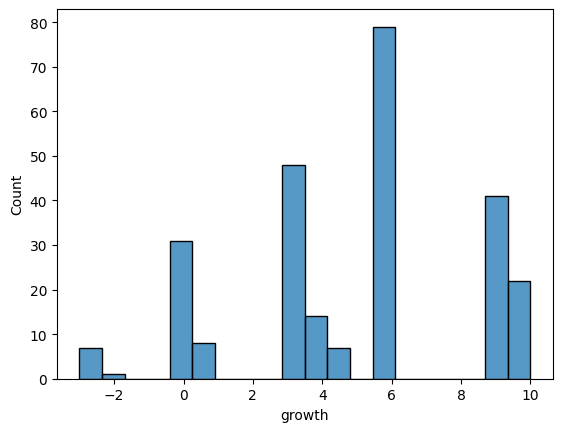

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df, x="growth", bins=20)
plt.show()

## Negative growth

In [25]:
df[df['growth'] < 0]

,r1,r3,r2,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,outputK,r14,r15,r16,InputA,InputI,OutputX,OutputN,id,growth,status,strain,rxn_a,rxn_b,rxn_c,no_deletions,del_r4,del_r2,del_OutputN,del_r10,del_r3,del_r14,del_InputA,del_r15,del_InputI
243,0.000000e+00,0.1,-1.100000,-2.200000,1.200000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.480297e-16,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,2.220446e-16,0.000000e+00,1.000000e+00,0.0,0.0,-3.000000e+00,1.0,"InputA,InputI",-3.000000e+00,infeasible,1,InputA,InputI,None,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
684,0.000000e+00,0.0,-1.000000,-2.000000,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.480297e-16,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,-3.330669e-16,0.000000e+00,1.000000e+00,0.0,0.0,-3.000000e+00,1.0,"r3,InputA,InputI",-3.000000e+00,infeasible,1,r3,InputA,InputI,3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
874,0.000000e+00,-1.0,0.000000,0.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.480297e-16,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,2.220446e-16,0.000000e+00,1.000000e+00,0.0,0.0,-3.000000e+00,1.0,"r2,InputA,InputI",-3.000000e+00,infeasible,1,r2,InputA,InputI,3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1045,0.000000e+00,-1.0,0.000000,0.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.480297e-16,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,2.220446e-16,0.000000e+00,1.000000e+00,0.0,0.0,-3.000000e+00,1.0,"r4,InputA,InputI",-3.000000e+00,infeasible,1,r4,InputA,InputI,3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1728,0.000000e+00,0.1,-1.100000,-2.200000,1.200000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.480297e-16,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,2.220446e-16,0.000000e+00,1.000000e+00,0.0,0.0,-3.000000e+00,1.0,"r10,InputA,InputI",-3.000000e+00,infeasible,1,r10,InputA,InputI,3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1958,2.960595e-16,0.1,-1.100000,-2.200000,1.200000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.480297e-16,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,-2.220446e-16,0.000000e+00,1.000000e+00,0.0,0.0,-3.000000e+00,1.0,"r14,InputA,InputI",-3.000000e+00,infeasible,1,r14,InputA,InputI,3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1979,2.960595e-16,0.1,-1.100000,-2.200000,1.200000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.480297e-16,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,-2.220446e-16,0.000000e+00,1.000000e+00,0.0,0.0,-3.000000e+00,1.0,"r15,InputA,InputI",-3.000000e+00,infeasible,1,r15,InputA,InputI,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2009,7.401487e-17,0.1,-0.433333,-0.866667,2.000000e-01,-6.666667e-01,-6.666667e-01,-1.000000e+00,-1.110223e-16,3.333333e-01,3.333333e-01,2.775558e-16,2.775558e-16,1.0,3.333333e-01,3.333333e-01,3.515706e-16,0.0,0.0,-2.000000e+00,0.0,"InputA,InputI,OutputN",-2.000000e+00,infeasible,1,InputA,InputI,OutputN,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2544,1.000000e+00,0.0,0.000000,0.000000,-4.255855e-16,-2.035409e-15,-1.924387e-15,-1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-1.572816e-16,-1.110223e-16,3.0,1.000000e+00,1.000000e+00,1.000000e+00,1.0,0.0,-1.332268e-15,0.0,"r3,r2,OutputN",-1.332268e-15,optimal,2,r3,r2,OutputN,3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2562,1.000000e+00,0.0,0.000000,0.000000,-7.956598e-16,-2.072416e-15,-1.942890e-15,-1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-2.220446e-16,-1.110223e-16,3.0,1.000000e+00,1.000000e+00,1.000000e+00,1.0,0.0,-2.997602e-15,0.0,"r3,r4,OutputN",-2.997602e-15,optimal,2,r3,r4,OutputN,3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


11 rows of __negative__ growth

Replace negative growth with 0

In [26]:
for row in range(len(df)):
    if(df['growth'].iloc[row] < 0): df['growth'].iloc[row] = 0

/tmp/ipykernel_9775/766195947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if(df['growth'].iloc[row] < 0): df['growth'].iloc[row] = 0


## Create _dummy variables_ for `status`

In [27]:
dummy_status = pd.get_dummies(df['status'])
df = pd.concat([df, dummy_status], axis=1)
df.head()

,r1,r3,r2,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,outputK,r14,r15,r16,InputA,InputI,OutputX,OutputN,id,growth,status,strain,rxn_a,rxn_b,rxn_c,no_deletions,del_r4,del_r2,del_OutputN,del_r10,del_r3,del_r14,del_InputA,del_r15,del_InputI,infeasible,optimal
1,1.0,0.0,1.0,2.0,1.0,3.0,3.0,3.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,9.0,1.0,r3,9.0,optimal,1,r3,None,None,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1
2,1.0,1.0,0.0,0.0,3.0,3.0,3.0,3.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,9.0,1.0,r2,9.0,optimal,1,r2,None,None,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
3,1.0,1.0,0.0,0.0,3.0,3.0,3.0,3.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,9.0,1.0,r4,9.0,optimal,1,r4,None,None,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
9,1.0,0.1,0.9,1.8,1.2,3.0,3.0,3.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,9.0,1.0,r10,9.0,optimal,1,r10,None,None,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1
14,1.0,0.1,0.9,1.8,1.2,3.0,3.0,3.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,9.0,1.0,r14,9.0,optimal,1,r14,None,None,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1


### Check Linear Correlations

##### Point Biserial Correlation

In [28]:
pearsons = df.drop(columns=critical_rxn).corr(numeric_only=True)['optimal'].sort_values(ascending=False)
spearman = df.drop(columns=critical_rxn).corr(numeric_only=True, method='spearman')['optimal'].sort_values(ascending=False)

corr_matrix = pd.DataFrame({'pearsons':pearsons, 'spearman':spearman})
corr_matrix.sort_values(by='pearsons')

,pearsons,spearman
infeasible,-1.000000,-1.000000
no_deletions,-0.250378,-0.241754
InputI,-0.218214,-0.218214
r14,-0.207541,-0.296564
r15,-0.207541,-0.160858
del_InputA,-0.186290,-0.186290
del_r4,-0.130705,-0.130705
del_r2,-0.130705,-0.130705
OutputN,-0.127978,-0.107804
del_OutputN,-0.112176,-0.112176


In [29]:
corr_matrix[abs(corr_matrix['pearsons']) < 0.1]

,pearsons,spearman
del_InputI,-0.056591,-0.056591
del_r10,-0.001005,-0.001005
del_r14,0.091637,0.091637
del_r15,0.091637,0.091637
del_r3,0.091637,0.091637
growth,0.048571,0.053886
r10,0.007492,0.128375
r2,-0.074485,-0.134973
r4,-0.074485,-0.100510


# AI / ML Ideas

## Create _training_ and _test_ sets and _data normalization_

Create a `df` keeping only _non critical_ reactions.

In [30]:
df.drop(columns=critical_rxn, inplace=True)

In [31]:
df.columns

Index(['r3', 'r2', 'r4', 'r10', 'r14', 'r15', 'InputA', 'InputI', 'OutputN',
       'id', 'growth', 'status', 'strain', 'rxn_a', 'rxn_b', 'rxn_c',
       'no_deletions', 'del_r4', 'del_r2', 'del_OutputN', 'del_r10', 'del_r3',
       'del_r14', 'del_InputA', 'del_r15', 'del_InputI', 'infeasible',
       'optimal'],
      dtype='object')

In [32]:
cols_to_drop = ['id', 'rxn_a', 'rxn_b', 'rxn_c', 'status']
df.drop(columns=cols_to_drop, inplace=True)

df.head()

,r3,r2,r4,r10,r14,r15,InputA,InputI,OutputN,growth,strain,no_deletions,del_r4,del_r2,del_OutputN,del_r10,del_r3,del_r14,del_InputA,del_r15,del_InputI,infeasible,optimal
1,0.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,9.0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,9.0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,9.0,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
9,0.1,0.9,1.8,0.0,0.0,0.0,1.0,1.0,1.0,9.0,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1
14,0.1,0.9,1.8,0.0,0.0,0.0,1.0,1.0,1.0,9.0,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1


In [33]:
df.shape

(258, 23)

### Basic ML libraries

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Define **target** variable

We need to better define the target that we want to predict!

(The most simple and obvious answer is to predit **optimal** column)

Θα *δοκιμάσω* να χρησιμοποιήσω ως στόχο την πρόβλεψη του αν πρόκειται για infeasible

In [37]:
# df['target'] = (1-df['good_growth']) * df['infeasible']
df['target'] = df['infeasible']
df['target'].value_counts()

0    178
1     80
Name: target, dtype: int64

In [30]:
df.columns

Index(['r3', 'r2', 'r4', 'r10', 'r14', 'r15', 'InputA', 'InputI', 'OutputN',
       'growth', 'strain', 'no_deletions', 'del_r2', 'del_OutputN', 'del_r14',
       'del_r3', 'del_r4', 'del_InputA', 'del_r15', 'del_InputI', 'del_r10',
       'infeasible', 'optimal', 'good_growth', 'target'],
      dtype='object')

In [31]:
X = df.drop(['optimal', 'infeasible', 'growth', 'strain', 'no_deletions', 'good_growth', 'target'], axis=1)
y = df['target']

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, stratify=y, random_state=42)

(258, 18)
(258,)


In [34]:
X_train.columns

Index(['r3', 'r2', 'r4', 'r10', 'r14', 'r15', 'InputA', 'InputI', 'OutputN',
       'del_r2', 'del_OutputN', 'del_r14', 'del_r3', 'del_r4', 'del_InputA',
       'del_r15', 'del_InputI', 'del_r10'],
      dtype='object')

Use of stratify sampling to get the same optimal/infeasible rates on train and test sets as to the original dataset.

In [35]:
# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression().fit(X_train_scaled, y_train)

validation_classification(lr_model, X_test_scaled, y_test)

ROC-AUC = 0.9606060606060606
ACCURACY = 0.9615384615384616
F1 = 0.9545454545454546


### SVM Classifier

In [37]:
svc_model, svc_scores = train_svm(X_train_scaled, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [38]:
validation_classification(svc_model, X_test_scaled, y_test)

ROC-AUC = 1.0
ACCURACY = 1.0
F1 = 1.0


### XGBoost Classifier

In [39]:
xgb_model, xgb_scores = xgb_classifier(X_train_scaled, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3; 1/20] START C=0.1, gamma=2, kernel=rbf.................................
[CV 1/3; 1/20] END ..C=0.1, gamma=2, kernel=rbf;, score=0.992 total time=   0.0s
[CV 1/3; 4/20] START C=0.05, gamma=2, kernel=linear.............................
[CV 1/3; 4/20] END C=0.05, gamma=2, kernel=linear;, score=0.986 total time=   0.0s
[CV 3/3; 4/20] START C=0.05, gamma=2, kernel=linear.............................
[CV 3/3; 4/20] END C=0.05, gamma=2, kernel=linear;, score=0.964 total time=   0.0s
[CV 2/3; 5/20] START C=0.05, gamma=0.1, kernel=rbf..............................
[CV 2/3; 5/20] END C=0.05, gamma=0.1, kernel=rbf;, score=1.000 total time=   0.0s
[CV 2/3; 6/20] START C=10, gamma=5, kernel=linear...............................
[CV 2/3; 6/20] END C=10, gamma=5, kernel=linear;, score=0.981 total time=   0.0s
[CV 3/3; 7/20] START C=0.01, gamma=0.1, kernel=rbf.............

[CV 1/3; 3/20] START C=0.5, gamma=10, kernel=linear.............................
[CV 1/3; 3/20] END C=0.5, gamma=10, kernel=linear;, score=0.972 total time=   0.0s
[CV 2/3; 13/20] START C=10, gamma=1, kernel=linear..............................
[CV 2/3; 13/20] END C=10, gamma=1, kernel=linear;, score=0.981 total time=   0.0s
[CV 3/3; 15/20] START C=0.01, gamma=0.01, kernel=rbf............................
[CV 3/3; 15/20] END C=0.01, gamma=0.01, kernel=rbf;, score=0.979 total time=   0.0s
[CV 1/3; 16/20] START C=0.05, gamma=1, kernel=linear............................
[CV 1/3; 16/20] END C=0.05, gamma=1, kernel=linear;, score=0.986 total time=   0.0s
[CV 1/3; 19/20] START C=100, gamma=0.1, kernel=linear...........................
[CV 1/3; 19/20] END C=100, gamma=0.1, kernel=linear;, score=1.000 total time=   0.0s
[CV 2/3; 19/20] START C=100, gamma=0.1, kernel=linear...........................
[CV 2/3; 19/20] END C=100, gamma=0.1, kernel=linear;, score=0.988 total time=   0.0s
[CV 3/3; 2/

[CV 1/3; 2/20] START C=0.1, gamma=0.01, kernel=rbf..............................
[CV 1/3; 2/20] END C=0.1, gamma=0.01, kernel=rbf;, score=1.000 total time=   0.0s
[CV 1/3; 3/20] START C=0.5, gamma=10, kernel=linear.............................
[CV 1/3; 3/20] END C=0.5, gamma=10, kernel=linear;, score=0.975 total time=   0.0s
[CV 3/3; 5/20] START C=0.05, gamma=0.1, kernel=rbf..............................
[CV 3/3; 5/20] END C=0.05, gamma=0.1, kernel=rbf;, score=1.000 total time=   0.0s
[CV 2/3; 10/20] START C=0.01, gamma=10, kernel=linear...........................
[CV 2/3; 10/20] END C=0.01, gamma=10, kernel=linear;, score=0.977 total time=   0.0s
[CV 3/3; 10/20] START C=0.01, gamma=10, kernel=linear...........................
[CV 3/3; 10/20] END C=0.01, gamma=10, kernel=linear;, score=0.796 total time=   0.0s
[CV 3/3; 15/20] START C=0.01, gamma=0.01, kernel=rbf............................
[CV 3/3; 15/20] END C=0.01, gamma=0.01, kernel=rbf;, score=1.000 total time=   0.0s
[CV 1/3; 16/2

In [40]:
validation_classification(xgb_model, X_test_scaled, y_test)

ROC-AUC = 1.0
ACCURACY = 1.0
F1 = 1.0


# Feature Importance to detect reactions for knock-out

In [41]:
import shap

explainer = shap.TreeExplainer(xgb_model, X_test_scaled, feature_names=X_test.columns)
shap_values = explainer(X_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


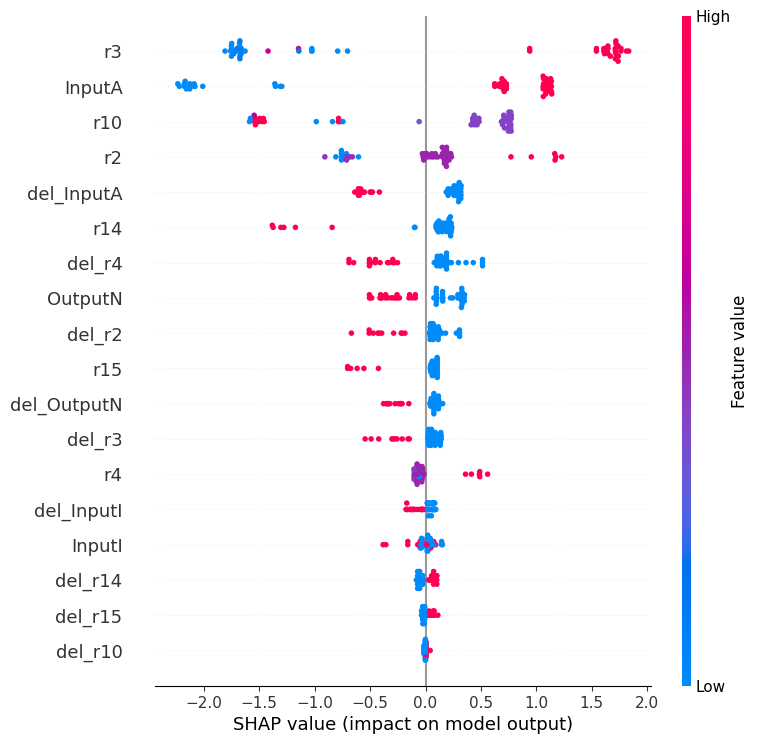

In [42]:
shap.plots.beeswarm(shap_values, max_display=X_train.shape[1])

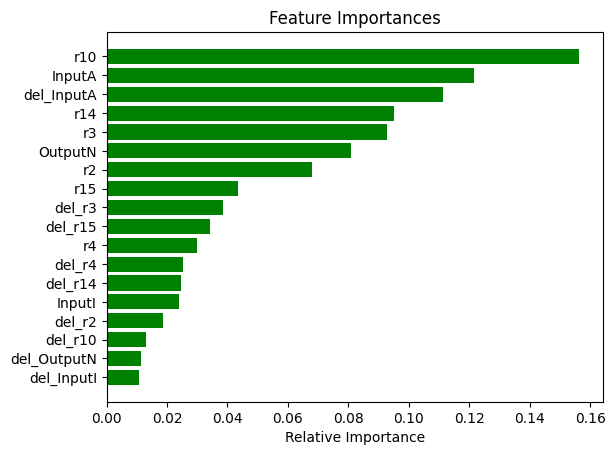

In [44]:
importances = xgb_model.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Artificial Neural Networks

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

2022-11-14 17:44:24.482438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 17:44:24.623944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-14 17:44:24.623964: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-14 17:44:24.650724: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-14 17:44:25.253213: W tensorflow/stream_executor/platform/de

In [46]:
n_inputs = len(X_train.columns)

In [ ]:
model = Sequential()
model.add(Dense(30, input_dim=n_inputs, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])

history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=5)

In [ ]:
score = model.evaluate(X_test_scaled, y_test,verbose=1)

In [ ]:
import shap


explainer = shap.DeepExplainer(model, X_train_scaled)

In [ ]:
shap_values = explainer.shap_values(X_test_scaled)

In [ ]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = X_test.columns, max_display=X_test.shape[1])

# ELI5 

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances
from sklearn.svm import SVC

perm = PermutationImportance(xgb_model).fit(X_test_scaled, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

# Feature Selection

In [59]:
from sklearn.feature_selection import RFE

estimator = xgb_model

selector = RFE(estimator, n_features_to_select=4, step=1)
selector = selector.fit(X_train_scaled, y_train)

selected_features = pd.DataFrame()
selected_features['selected'] = selector.support_
selected_features['features_names'] = X_train.columns
selected_features['rank'] = selector.ranking_
selected_features[selected_features['selected'] == True]

,selected,features_names,rank
0,True,r3,1
4,True,r14,1
6,True,InputA,1
14,True,del_InputA,1


In [60]:
estimator = xgb.XGBClassifier()

selector = RFE(estimator, n_features_to_select=4, step=1)
selector = selector.fit(X_train_scaled, y_train)

selected_features = pd.DataFrame()
selected_features['selected'] = selector.support_
selected_features['features_names'] = X_train.columns
selected_features['rank'] = selector.ranking_
selected_features[selected_features['selected'] == True]

,selected,features_names,rank
0,True,r3,1
3,True,r10,1
4,True,r14,1
6,True,InputA,1


In [61]:
selected_features[selected_features['selected'] == False].sort_values(by='rank')

,selected,features_names,rank
13,False,del_r4,2
1,False,r2,3
9,False,del_r2,4
7,False,InputI,5
8,False,OutputN,6
10,False,del_OutputN,7
17,False,del_r10,8
11,False,del_r14,9
15,False,del_r15,10
16,False,del_InputI,11


# Validate Deletions

In [49]:
from cobra.io import load_model
from cobra.io.json import load_json_model

from main import *

# cobra_model = load_model("textbook")

# Load toy models created by Stefanos
cobra_model_1 = load_json_model('toy_1.json')
cobra_model_2 = load_json_model('toy_2.json')

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [63]:
ann = ['r3', 'r15', 'r4']

with cobra_model_1:
    for rxn in ann:
        cobra_model_1.reactions.get_by_id(rxn).knock_out()
    solution =  cobra_model_1.optimize()    
    print(solution.objective_value)
    print(solution.status)

with cobra_model_2:
    for rxn in ann:
        cobra_model_2.reactions.get_by_id(rxn).knock_out()
    solution =  cobra_model_2.optimize()    
    print(solution.objective_value)
    print(solution.status)

9.0
infeasible
3.0000000000000004
optimal


Solver status is 'infeasible'.
